2/2 [==============================] - 0s 8ms/step
Эпоха 1, Дискриминатор Real=[0.0025217216461896896, 1.0], Fake=[0.02402413822710514, 1.0], Генератор=5.234065055847168
1/1 [==============================] - 0s 252ms/step


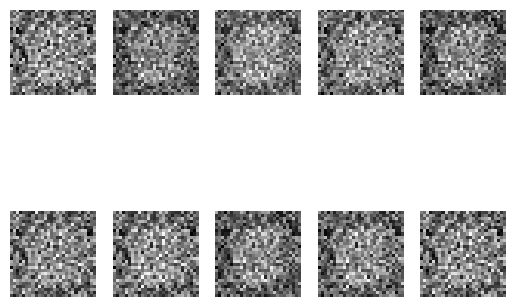

2/2 [==============================] - 0s 8ms/step
Эпоха 2, Дискриминатор Real=[0.03957904130220413, 1.0], Fake=[0.045058343559503555, 1.0], Генератор=4.2876152992248535
1/1 [==============================] - 0s 80ms/step


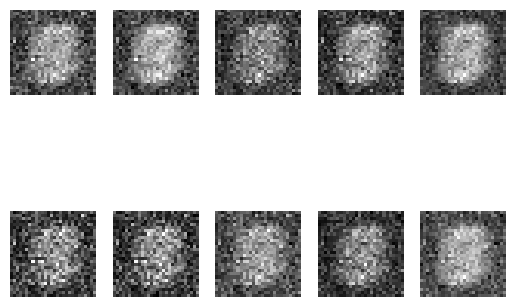

2/2 [==============================] - 0s 6ms/step
Эпоха 3, Дискриминатор Real=[0.050754740834236145, 1.0], Fake=[0.07057325541973114, 0.984375], Генератор=5.1874284744262695
1/1 [==============================] - 0s 76ms/step


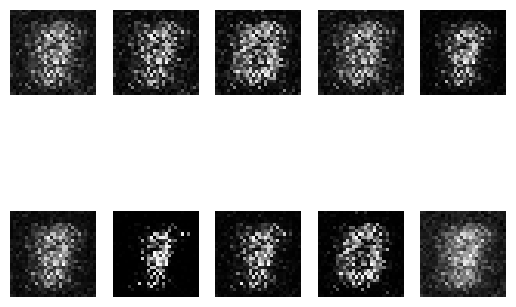

2/2 [==============================] - 0s 8ms/step
Эпоха 4, Дискриминатор Real=[0.10519937425851822, 0.96875], Fake=[0.04343468323349953, 0.984375], Генератор=6.0876665115356445
1/1 [==============================] - 0s 105ms/step


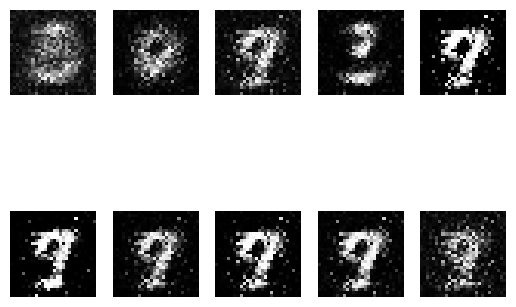

2/2 [==============================] - 0s 7ms/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Определение архитектуры генератора
def build_generator(z_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=z_dim))
    model.add(layers.LeakyReLU(alpha=0.01))
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Определение архитектуры дискриминатора
def build_discriminator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.01))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Построение и компиляция GAN
def build_gan(generator, discriminator):
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Загрузка и предобработка данных MNIST
def load_real_samples():
    (train_images, _), (_, _) = mnist.load_data()
    # Масштабирование изображений до [-1, 1]
    X = train_images.astype('float32')
    X = (X - 127.5) / 127.5
    X = np.expand_dims(X, axis=-1)
    return X

def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = np.ones((n_samples, 1))
    return X, y

def generate_fake_samples(generator, z_dim, n_samples):
    z = np.random.normal(0, 1, (n_samples, z_dim))
    images = generator.predict(z)
    y = np.zeros((n_samples, 1))
    return images, y

# Функция отображения сгенерированных изображений
def sample_images(generator, z_dim, epoch):
    r, c = 2, 5
    z = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(z)

    # Масштабирование изображений от [-1, 1] к [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

# Обучение GAN с отображением изображений
def train_gan(generator, discriminator, gan, dataset, z_dim, epochs=100, batch_size=128):
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        for _ in range(dataset.shape[0] // batch_size):
            # Генерация реальных и фальшивых изображений
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(generator, z_dim, half_batch)

            # Обучение дискриминатора
            discriminator_loss_real = discriminator.train_on_batch(X_real, y_real)
            discriminator_loss_fake = discriminator.train_on_batch(X_fake, y_fake)

            # Подготовка точек в латентном пространстве
            z_input = np.random.normal(0, 1, (batch_size, z_dim))
            y_gan = np.ones((batch_size, 1))

            # Обучение генератора
            generator_loss = gan.train_on_batch(z_input, y_gan)

        # Вывод прогресса и отображение сгенерированных изображений
        print(f"Эпоха {epoch+1}, Дискриминатор Real={discriminator_loss_real}, Fake={discriminator_loss_fake}, Генератор={generator_loss}")
        sample_images(generator, z_dim, epoch)

# Задаем размерности
z_dim = 100
img_shape = (28, 28, 1)

# Создаем сети
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

generator = build_generator(z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

# Загрузка данных
dataset = load_real_samples()

# Обучение модели
train_gan(generator, discriminator, gan, dataset, z_dim, epochs=100, batch_size=128)
